Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Flatten, Bidirectional
from sklearn.metrics import confusion_matrix
import keras
import os
import pickle
import gc

Para guardar os modelos e as metricas em disco

In [3]:
def save_pkl(data, path):
    try:
        with open(path, "wb") as saved_data:
            pickle.dump(data, saved_data)
    except:
        print('Fail to save data')

def load_pkl(path):
    try:
        with open(path, "rb") as loaded_data:
            to_return = pickle.load(loaded_data)
            return to_return
    except:
        print('Fail to load data')
        return None

Metadata

In [2]:
df = pd.read_csv("../UrbanSound8K/metadata/UrbanSound8K.csv")
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


Distribuição das Classes

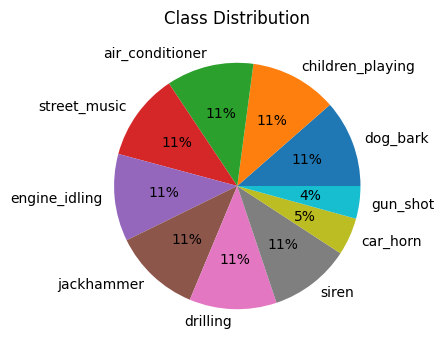

In [4]:
df['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', figsize=(4,4))
plt.title('Class Distribution')
plt.ylabel('')
plt.show()

## Feature Extraction and Pre-processing

### Padding of the Audio to a Fixed Length

In [5]:
def padding(path, duration = 4, sr = 44100):
    files = librosa.util.find_files(path)
    data = []

    for index, file_path in enumerate(files):
        try:
            audio, sr = librosa.load(file_path, sr=sr, mono=True)

            if len(audio) < duration*sr: # quando a duracao do audio for inferior aos 4 seg vamos adicionar padding
                audio = np.concatenate([audio,np.zeros(shape = (duration*sr - len(audio), ))])

            elif len(audio) > duration*sr: # quando a duracao do audio for superior aos 4 segs vamos reduzir a duracao
                audio = audio[:duration*sr]
        
            file_name = os.path.basename(file_path)
            data.append([file_name, audio])
        
        except Exception:
            print(f"Error in processig file {file_path}: {Exception}")

    return data

### Feature Extraction

189895-3-0-0.wav


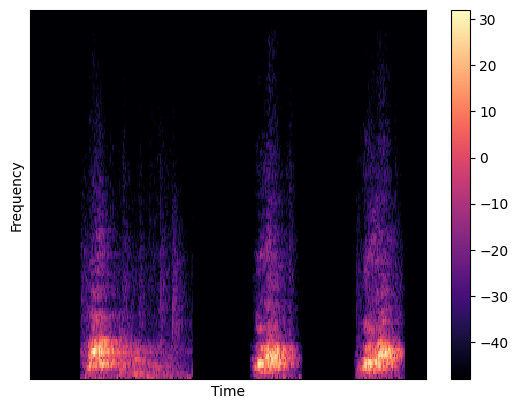

In [6]:
# uma amostra para visualizar
sample_num = 4729

filename = df.slice_file_name[sample_num] # nome da amostra
print(filename)

path = '../UrbanSound8K/audio/fold' + str(df.fold[sample_num]) + '/' + str(filename)
signal, sr = librosa.load(path, sr = 44100)

n_fft = 256
hop_length = 512

stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)
spectogram = np.abs(stft)
log_spectogram = librosa.amplitude_to_db(spectogram)

librosa.display.specshow(log_spectogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

In [7]:
def feature_extraction(dataframe, audios, hop_length = 512, n_fft = 256):
    log_spectograms = []
    labels = []

    for index in range(len(audios)):
        try:
            file_name =audios[index][0]
            if file_name:
                row = dataframe.loc[dataframe["slice_file_name"] == file_name]

                if not row.empty:
                    label = row.iloc[0,6]
                    spectogram = np.abs(librosa.core.stft(
                        y = np.array(audios[index][1]),
                        hop_length = hop_length,
                        n_fft = n_fft
                    ))
                    log_spectogram = librosa.amplitude_to_db(spectogram)
                    log_spectograms.append(log_spectogram)
                    labels.append(label)
        except Exception:
            print(f"Error in processig file {audios[index][0]}: {Exception}")

    log_spectograms = np.array(log_spectograms)
    labels = np.array(labels)
    return log_spectograms, labels



### Data Normalization and Pre-processing

In [8]:
fold_paths = ["../UrbanSound8K/audio/fold1",
              "../UrbanSound8K/audio/fold2",
              "../UrbanSound8K/audio/fold3",
              "../UrbanSound8K/audio/fold4",
              "../UrbanSound8K/audio/fold5",
              "../UrbanSound8K/audio/fold6",
              "../UrbanSound8K/audio/fold7",
              "../UrbanSound8K/audio/fold8",
              "../UrbanSound8K/audio/fold9",
              "../UrbanSound8K/audio/fold10"]

In [9]:
features = np.empty((10,), dtype=object)
label = np.empty((10,), dtype=object)

for i, fold in enumerate(fold_paths):
    print(f"Processing Fold Number {i+1}")
    audio_data = padding(fold)
    log_spectograms, labels = feature_extraction(df, audio_data)

    # normalizar os dados para estarem entre valores [0,1]
    log_spectograms_normalized = (log_spectograms - np.min(log_spectograms)) / (np.max(log_spectograms) - np.min(log_spectograms))

    # one-hot encoding dos labels
    encoded_labels = np.zeros((len(labels), 10))
    encoded_labels[np.arange(len(labels)), labels] = 1
    
    features[i] = log_spectograms_normalized
    label[i] = encoded_labels
    print("Features Shape: ",features[i].shape)
    print("Labels Shape: ",label[i].shape,"\n")
    
    del log_spectograms
    del log_spectograms_normalized
    del labels
    del encoded_labels
    gc.collect() # libertar memoria

Processing Fold Number 1
Features Shape:  (873, 129, 345)
Labels Shape:  (873, 10) 

Processing Fold Number 2
Features Shape:  (888, 129, 345)
Labels Shape:  (888, 10) 

Processing Fold Number 3
Features Shape:  (925, 129, 345)
Labels Shape:  (925, 10) 

Processing Fold Number 4
Features Shape:  (990, 129, 345)
Labels Shape:  (990, 10) 

Processing Fold Number 5
Features Shape:  (936, 129, 345)
Labels Shape:  (936, 10) 

Processing Fold Number 6
Features Shape:  (823, 129, 345)
Labels Shape:  (823, 10) 

Processing Fold Number 7
Features Shape:  (838, 129, 345)
Labels Shape:  (838, 10) 

Processing Fold Number 8
Features Shape:  (806, 129, 345)
Labels Shape:  (806, 10) 

Processing Fold Number 9
Features Shape:  (816, 129, 345)
Labels Shape:  (816, 10) 

Processing Fold Number 10
Features Shape:  (837, 129, 345)
Labels Shape:  (837, 10) 



## Model Architecture

#### 1. Input Layer
- Shape: (x, y) where:
  - x is the number of timesteps (sequence length).
  - y is the number of features per timestep (e.g., MFCC coefficients).
- Purpose: The model expects a sequential input where each timestep represents a feature vector of the audio signal.
#### 2. First Bidirectional LSTM Layer
Description: A Bidirectional LSTM with 128 units.
- Bidirectionality: Processes the sequence in both forward and backward directions to capture dependencies in the audio signal from past and future timesteps.
- Activation: tanh for non-linearity.
- Kernel Initialization: glorot_uniform for balanced weight initialization.
- Output: Produces a sequence of 128 features for each timestep.
- Dropout (0.3): <b>Randomly drops 30% of connections to prevent overfitting.</b>
- Batch Normalization: <b>Normalizes the output of the LSTM layer, ensuring stability during training by keeping activations in a consistent range.</b>

#### 3. Second Bidirectional LSTM Layer
Description: Another Bidirectional LSTM with 128 units.
- Purpose: Further refines temporal features extracted from the first LSTM layer, learning more complex patterns.
- Output: Produces a sequence of 128 features for each timestep.
- Dropout (0.3): <b>Again, drops 30% of connections for regularization.</b>
- Batch Normalization: <b>Stabilizes activations and accelerates convergence.</b>

#### 4. TimeDistributed Dense Layers
Description: Fully connected layers applied independently to each timestep. These layers transform the feature representation at each timestep into higher-level abstractions.
- First Dense Layer:
  - Units: 128 neurons.
  - Activation: ReLU for faster training and reduced vanishing gradient issues.
  - Regularization: L2 regularization (0.01) to prevent overfitting.
  - Dropout (0.2): Drops 20% of connections.
- Second Dense Layer:
  - Units: 64 neurons.
  - Activation: ReLU.
  - Regularization: L2 regularization (0.01).
  - Dropout (0.2).
  - Purpose: These layers learn high-level feature transformations for each timestep.

#### 5. Flatten Layer
Description: Flattens the outputs of the TimeDistributed Dense layers into a single vector.
- Purpose: Converts the 2D sequence of features into a 1D vector suitable for final classification.

#### 6. Output Layer
Description: A fully connected Dense layer with 10 neurons.
- Activation: Softmax, which outputs a probability distribution over the 10 sound classes.
- Purpose: Final classification into one of the 10 categories.

training strategies

### modelo

In [13]:
def create_model(x, y):
    input_shape = (x,y)  # Shape do set de treino

    model = Sequential()

    # LSTM layers
    model.add(LSTM(128, return_sequences=True, activation='tanh', kernel_initializer='random_normal',input_shape=input_shape))
    model.add(Bidirectional(LSTM(64, return_sequences=True, activation='tanh')))

    # TimeDistributed Dense layers
    model.add(TimeDistributed(Dense(64, activation='tanh', kernel_regularizer=regularizers.l2(0.01))))
    model.add(Dropout(0.4))
    model.add(TimeDistributed(Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(0.01))))
    model.add(Dropout(0.4))
    model.add(TimeDistributed(Dense(16, activation='tanh', kernel_regularizer=regularizers.l2(0.01))))
    model.add(Dropout(0.4))
    model.add(TimeDistributed(Dense(8, activation='tanh', kernel_regularizer=regularizers.l2(0.01))))
    model.add(Dropout(0.3))
    
    # Pooling to reduce sequence
    model.add(Flatten())

    # Output layers
    model.add(Dense(10, activation='softmax'))

    return model

In [16]:
model = create_model(129, 345)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 129, 128)       │       242,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 129, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 129, 64)        │         8,256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 129, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 129, 32)        │         2,080 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 129, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 129, 16)        │           528 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 129, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 129, 8)         │           136 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 129, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1032)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │        10,330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 362,834 (1.38 MB)

 Trainable params: 362,834 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
fold_metrics = []
EPOCHS = 50

sets_treino_val = [[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9],[9,0]] # [set_test,set_valid] | 0 = fold1 | 1 = fold2 | ...

for fold in range(10):
    print(f"Fold {fold+1}:")

    X_test, y_test =[], []
    X_val, y_val = [], []
    X_train, y_train = [], []

    # separar os dados(folds) em test(1) | validacao(1) | treino(8)
    for i in range(10):
        if i == sets_treino_val[fold][0]:
            # set de teste
            X_test = features[i]
            y_test = label[i]
        elif i == sets_treino_val[fold][1]:
            # set de validacao
            X_val = features[i]
            y_val = label[i]
            
        else:
            # agrupar sets para treino
            if len(X_train) == 0:  # inicializar no primeiro fold de treino
                X_train = features[i]
                y_train = label[i]
            else:
                X_train = np.concatenate((X_train, features[i]), axis=0)
                y_train = np.concatenate((y_train, label[i]), axis=0)


    # converter para np array caso ainda nao estejam
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    X_val = np.array(X_val)
    y_val = np.array(y_val)

    # Print set shapes
    # print(f"X_train Shape: {X_train.shape}")
    # print(f"y_train Shape: {y_train.shape}")
    # print(f"X_test Shape: {X_test.shape}")
    # print(f"y_test Shape: {y_test.shape}")
    # print(f"X_val Shape: {X_val.shape}")
    # print(f"y_val Shape: {y_val.shape}")

    # iniciar o modelo
    model = create_model(129, 345)

    # compilar o modelo com o optimizer Adam
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer, 
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )

    # treinar o modelo
    LSTM_model = model.fit(
        X_train, y_train, 
        epochs=EPOCHS,
        batch_size=32, 
        shuffle=False, 
        validation_data=(X_val, y_val)
    )

    # prever no set de test
    y_pred = model.predict(X_test)

    # avaliar o modelo
    y_pred_reshape = np.argmax(y_pred, axis=1)
    y_test_reshape = np.argmax(y_test, axis=1)
    TestLoss, Testacc = model.evaluate(X_test, y_test)

    # guardar os resultados para o guardar disco/visualizar no futuro
    m_metrics = {
        'loss': TestLoss, 
        'accuracy': Testacc, 
        'confusion_matrix': confusion_matrix(y_test_reshape, y_pred_reshape), 
        'history': model, 
        'history_dict': LSTM_model.history
    }

    fold_metrics.append(m_metrics)

    model.save(f"kfold_metrics_LSTM/model_fold{fold+1}.keras", save_format="keras")
    save_pkl(m_metrics, f"kfold_metrics_LSTM/metrics_fold{fold+1}.pkl")

    # eliminar o modelo para começar de novo para evitar memory leak
    del model
    keras.backend.clear_session()
    gc.collect()

    print("Done.")

Fold 1:
Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 38s 113ms/step - accuracy: 0.1017 - loss: 3.9998 - val_accuracy: 0.1126 - val_loss: 3.1943
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - accuracy: 0.1209 - loss: 3.1396 - val_accuracy: 0.1633 - val_loss: 2.9497
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 23s 105ms/step - accuracy: 0.1380 - loss: 2.7772 - val_accuracy: 0.1700 - val_loss: 2.5789
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 23s 107ms/step - accuracy: 0.1624 - loss: 2.5112 - val_accuracy: 0.1914 - val_loss: 2.4444
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 23s 106ms/step - accuracy: 0.1813 - loss: 2.3494 - val_accuracy: 0.2027 - val_loss: 2.3482
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 23s 105ms/step - accuracy: 0.1922 - loss: 2.2335 - val_accuracy: 0.2376 - val_loss: 2.2413
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 23s 107ms/step - accuracy: 0.2253 - loss: 2.1411 - val_accuracy: 0.2545 - val_loss: 2.2501
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 23s 106ms/step - accuracy: 0.2319 - 

Done.
Fold 2:


c:\Users\joaob\virt_env\aprend_comp_2\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 35s 102ms/step - accuracy: 0.0940 - loss: 4.1019 - val_accuracy: 0.1081 - val_loss: 3.1788
Epoch 2/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - accuracy: 0.1084 - loss: 3.1960 - val_accuracy: 0.1146 - val_loss: 2.8215
Epoch 3/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - accuracy: 0.0952 - loss: 2.7956 - val_accuracy: 0.1081 - val_loss: 2.6245
Epoch 4/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.1027 - loss: 2.6002 - val_accuracy: 0.1081 - val_loss: 2.5550
Epoch 5/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.0955 - loss: 2.4992 - val_accuracy: 0.1081 - val_loss: 2.4697
Epoch 6/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.0931 - loss: 2.4344 - val_accuracy: 0.1081 - val_loss: 2.3585
Epoch 7/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.0948 - loss: 2.3611 - val_accuracy: 0.1081 - val_loss: 2.3258
Epoch 8/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.1042 - loss: 2.3280 -

Done.
Fold 3:


c:\Users\joaob\virt_env\aprend_comp_2\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 33s 96ms/step - accuracy: 0.0902 - loss: 4.1124 - val_accuracy: 0.1000 - val_loss: 3.1886
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.1039 - loss: 3.1403 - val_accuracy: 0.1010 - val_loss: 2.9032
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.1224 - loss: 2.7823 - val_accuracy: 0.1010 - val_loss: 2.6754
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.1738 - loss: 2.5267 - val_accuracy: 0.1242 - val_loss: 2.5078
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.1735 - loss: 2.4008 - val_accuracy: 0.1091 - val_loss: 2.4478
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - accuracy: 0.1707 - loss: 2.3197 - val_accuracy: 0.1364 - val_loss: 2.3714
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.1795 - loss: 2.2440 - val_accuracy: 0.1475 - val_loss: 2.2978
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.2008 - loss: 2.1727 - 

Done.
Fold 4:


c:\Users\joaob\virt_env\aprend_comp_2\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 33s 95ms/step - accuracy: 0.0817 - loss: 4.1660 - val_accuracy: 0.1132 - val_loss: 3.2518
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - accuracy: 0.1073 - loss: 3.1728 - val_accuracy: 0.1410 - val_loss: 2.9998
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.1440 - loss: 2.7723 - val_accuracy: 0.1453 - val_loss: 2.8352
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.1740 - loss: 2.5541 - val_accuracy: 0.1442 - val_loss: 2.6476
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.1768 - loss: 2.3971 - val_accuracy: 0.1667 - val_loss: 2.4775
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.1893 - loss: 2.2969 - val_accuracy: 0.1859 - val_loss: 2.3507
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.2048 - loss: 2.2061 - val_accuracy: 0.2019 - val_loss: 2.3049
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.2067 - loss: 2.1596 - 

Done.
Fold 5:


c:\Users\joaob\virt_env\aprend_comp_2\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step - accuracy: 0.0975 - loss: 4.1172 - val_accuracy: 0.1094 - val_loss: 3.2056
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - accuracy: 0.1108 - loss: 3.2133 - val_accuracy: 0.1215 - val_loss: 2.8531
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.1125 - loss: 2.7956 - val_accuracy: 0.1567 - val_loss: 2.5939
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - accuracy: 0.1711 - loss: 2.5523 - val_accuracy: 0.1543 - val_loss: 2.4962
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - accuracy: 0.1857 - loss: 2.3800 - val_accuracy: 0.1580 - val_loss: 2.3842
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.1944 - loss: 2.2699 - val_accuracy: 0.1725 - val_loss: 2.2425
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - accuracy: 0.2119 - loss: 2.1824 - val_accuracy: 0.1689 - val_loss: 2.1948
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - accuracy: 0.2200 - loss: 2.1359 - 

Done.
Fold 6:


c:\Users\joaob\virt_env\aprend_comp_2\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 35s 103ms/step - accuracy: 0.0940 - loss: 4.0486 - val_accuracy: 0.0919 - val_loss: 3.1770
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.0931 - loss: 3.0973 - val_accuracy: 0.1205 - val_loss: 2.7849
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.1039 - loss: 2.7367 - val_accuracy: 0.2112 - val_loss: 2.5867
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.1242 - loss: 2.5500 - val_accuracy: 0.1850 - val_loss: 2.4642
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.1049 - loss: 2.4415 - val_accuracy: 0.2136 - val_loss: 2.3911
Epoch 6/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.1304 - loss: 2.3614 - val_accuracy: 0.1193 - val_loss: 2.3439
Epoch 7/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.1034 - loss: 2.3323 - val_accuracy: 0.0907 - val_loss: 2.3159
Epoch 8/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.1199 - loss: 2.3005 -

Done.
Fold 7:


c:\Users\joaob\virt_env\aprend_comp_2\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 35s 100ms/step - accuracy: 0.0985 - loss: 4.0403 - val_accuracy: 0.1241 - val_loss: 3.1859
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.0935 - loss: 3.1009 - val_accuracy: 0.1315 - val_loss: 2.7812
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.1176 - loss: 2.7531 - val_accuracy: 0.1303 - val_loss: 2.6274
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.1587 - loss: 2.5459 - val_accuracy: 0.2072 - val_loss: 2.4241
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.1711 - loss: 2.4133 - val_accuracy: 0.1749 - val_loss: 2.2945
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.2026 - loss: 2.2601 - val_accuracy: 0.1551 - val_loss: 2.2157
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.2247 - loss: 2.1819 - val_accuracy: 0.2283 - val_loss: 2.1396
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.2357 - loss: 2.1389 -

Done.
Fold 8:


c:\Users\joaob\virt_env\aprend_comp_2\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 36s 101ms/step - accuracy: 0.0983 - loss: 4.1590 - val_accuracy: 0.1446 - val_loss: 3.2355
Epoch 2/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - accuracy: 0.1066 - loss: 3.1945 - val_accuracy: 0.1912 - val_loss: 2.8448
Epoch 3/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.1340 - loss: 2.7894 - val_accuracy: 0.1924 - val_loss: 2.5384
Epoch 4/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.1811 - loss: 2.5283 - val_accuracy: 0.1875 - val_loss: 2.3517
Epoch 5/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.2031 - loss: 2.3481 - val_accuracy: 0.1667 - val_loss: 2.2323
Epoch 6/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.2052 - loss: 2.2426 - val_accuracy: 0.1667 - val_loss: 2.2314
Epoch 7/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.2184 - loss: 2.1833 - val_accuracy: 0.1703 - val_loss: 2.1402
Epoch 8/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.2301 - loss: 2.1345 -

Done.
Fold 9:


c:\Users\joaob\virt_env\aprend_comp_2\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 36s 101ms/step - accuracy: 0.0957 - loss: 4.0717 - val_accuracy: 0.1577 - val_loss: 3.1163
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.1082 - loss: 3.1093 - val_accuracy: 0.1756 - val_loss: 2.7300
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.1393 - loss: 2.7245 - val_accuracy: 0.2533 - val_loss: 2.5102
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.1833 - loss: 2.4714 - val_accuracy: 0.1589 - val_loss: 2.3670
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.2019 - loss: 2.3218 - val_accuracy: 0.2222 - val_loss: 2.2310
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.2056 - loss: 2.2286 - val_accuracy: 0.2389 - val_loss: 2.1451
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.2085 - loss: 2.1622 - val_accuracy: 0.2497 - val_loss: 2.1117
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.2131 - loss: 2.1186 -

Done.
Fold 10:


c:\Users\joaob\virt_env\aprend_comp_2\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 36s 103ms/step - accuracy: 0.1026 - loss: 4.1288 - val_accuracy: 0.1145 - val_loss: 3.1935
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.1072 - loss: 3.1534 - val_accuracy: 0.1340 - val_loss: 2.7639
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.1535 - loss: 2.7754 - val_accuracy: 0.2314 - val_loss: 2.4115
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - accuracy: 0.1724 - loss: 2.5531 - val_accuracy: 0.2520 - val_loss: 2.2912
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 22s 98ms/step - accuracy: 0.1944 - loss: 2.4014 - val_accuracy: 0.2600 - val_loss: 2.1257
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - accuracy: 0.1970 - loss: 2.3228 - val_accuracy: 0.2795 - val_loss: 2.0658
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - accuracy: 0.2037 - loss: 2.2343 - val_accuracy: 0.2829 - val_loss: 2.0298
Epoch 8/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - accuracy: 0.1942 - loss: 2.1823 -

Done.


## Performance Evaluation

Gráficos de loss | accuracy

In [23]:
fold_metrics

[{'loss': 2.3564066886901855,
  'accuracy': 0.38373425602912903,
  'confusion_matrix': array([[25,  0, 29,  1,  1,  8,  0,  4,  0, 32],
         [ 0, 12,  0, 15,  0,  0,  1,  0,  8,  0],
         [10,  0, 36, 24,  5,  3,  0,  1, 11, 10],
         [ 4,  4,  7, 64,  0,  4,  4,  0,  6,  7],
         [ 9,  4,  2, 13, 27,  2,  8, 20,  2, 13],
         [13,  0,  6, 23,  0, 21,  0, 17,  5, 11],
         [ 0,  0,  0,  3,  0,  4, 27,  1,  0,  0],
         [27,  4, 16,  0, 32,  1,  1, 28,  0, 11],
         [ 2,  0,  6,  2,  2,  9,  0,  2, 62,  1],
         [18,  5, 11,  7,  7, 11,  0,  4,  4, 33]], dtype=int64),
  'history': <Sequential name=sequential, built=True>,
  'history_dict': {'accuracy': [0.09697317332029343,
    0.12953665852546692,
    0.16740782558918,
    0.18562616407871246,
    0.21216468513011932,
    0.2226366400718689,
    0.24558886885643005,
    0.2567780911922455,
    0.27757853269577026,
    0.28374695777893066,
    0.291206419467926,
    0.3352460265159607,
    0.341701328

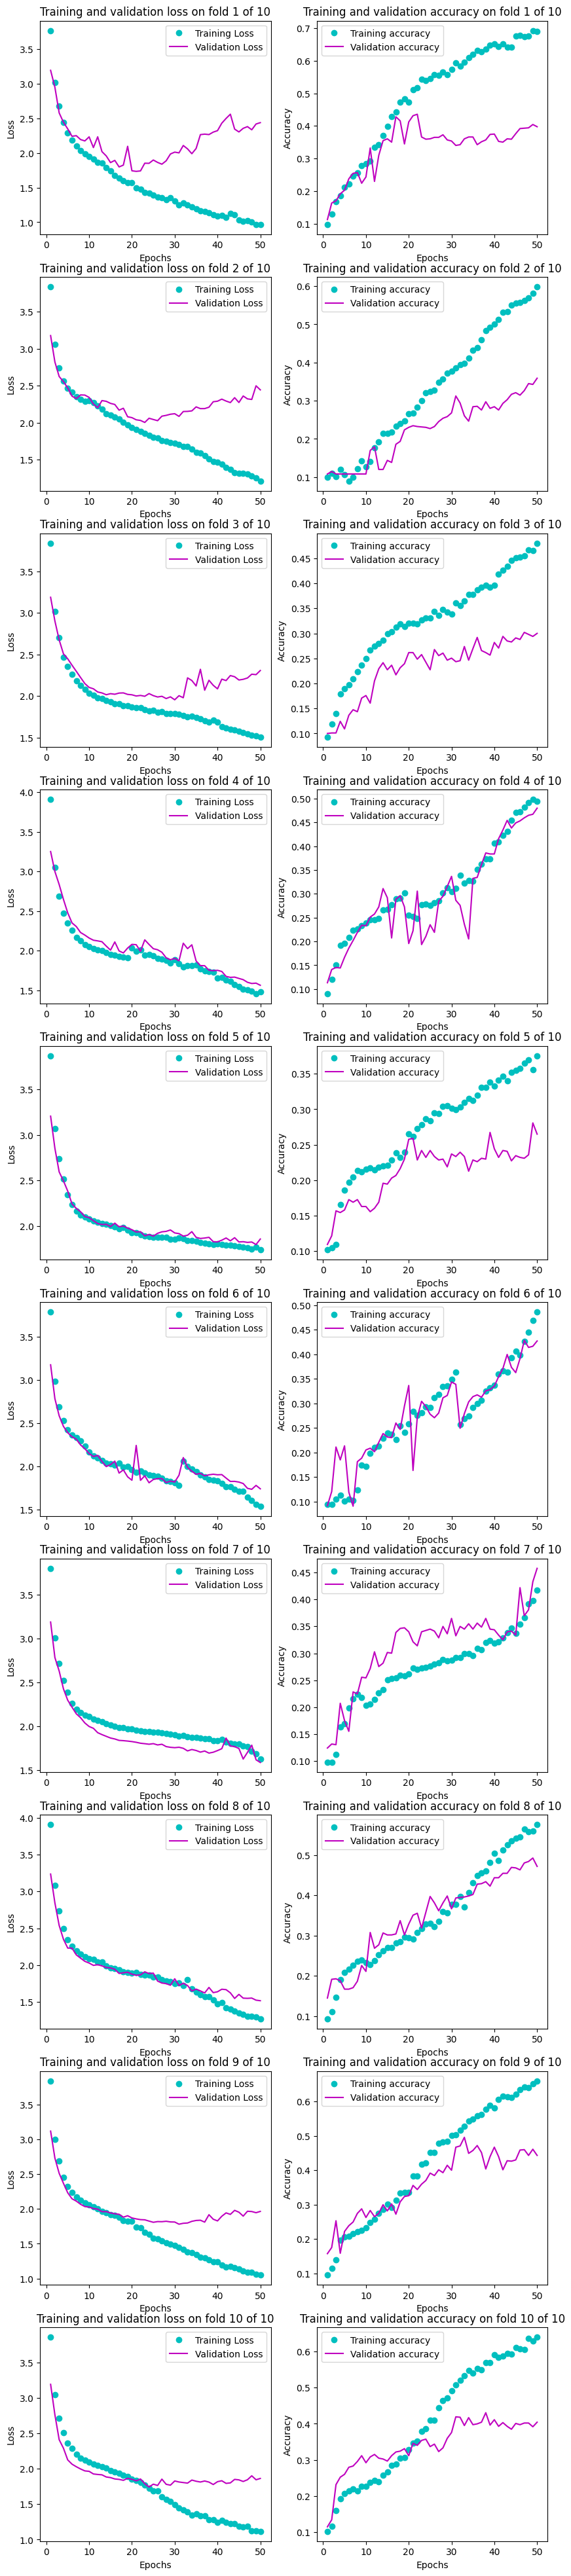

In [25]:
epochs = range(1, EPOCHS + 1)

fig, ax = plt.subplots(len(fold_metrics), 2, figsize=(10, 5*len(fold_metrics)))


for i in range(0,len(fold_metrics)):
    history_dict = fold_metrics[i].get('history_dict')
    loss_values=history_dict['loss']
    acc_values=history_dict['accuracy']
    val_loss_values = history_dict['val_loss']
    val_acc_values = history_dict['val_accuracy']

    ax[i,0].plot(epochs,loss_values,'co',label='Training Loss')
    ax[i,0].plot(epochs,val_loss_values,'m', label='Validation Loss')
    ax[i,0].set_title('Training and validation loss on fold '+str(i+1)+' of 10')
    ax[i,0].set_xlabel('Epochs')
    ax[i,0].set_ylabel('Loss')
    ax[i,0].legend()

    ax[i,1].plot(epochs,acc_values,'co', label='Training accuracy')
    ax[i,1].plot(epochs,val_acc_values,'m', label='Validation accuracy')
    ax[i,1].set_title('Training and validation accuracy on fold '+str(i+1)+' of 10')
    ax[i,1].set_xlabel('Epochs')
    ax[i,1].set_ylabel('Accuracy')
    ax[i,1].legend()
plt.show()

Matriz de confusão

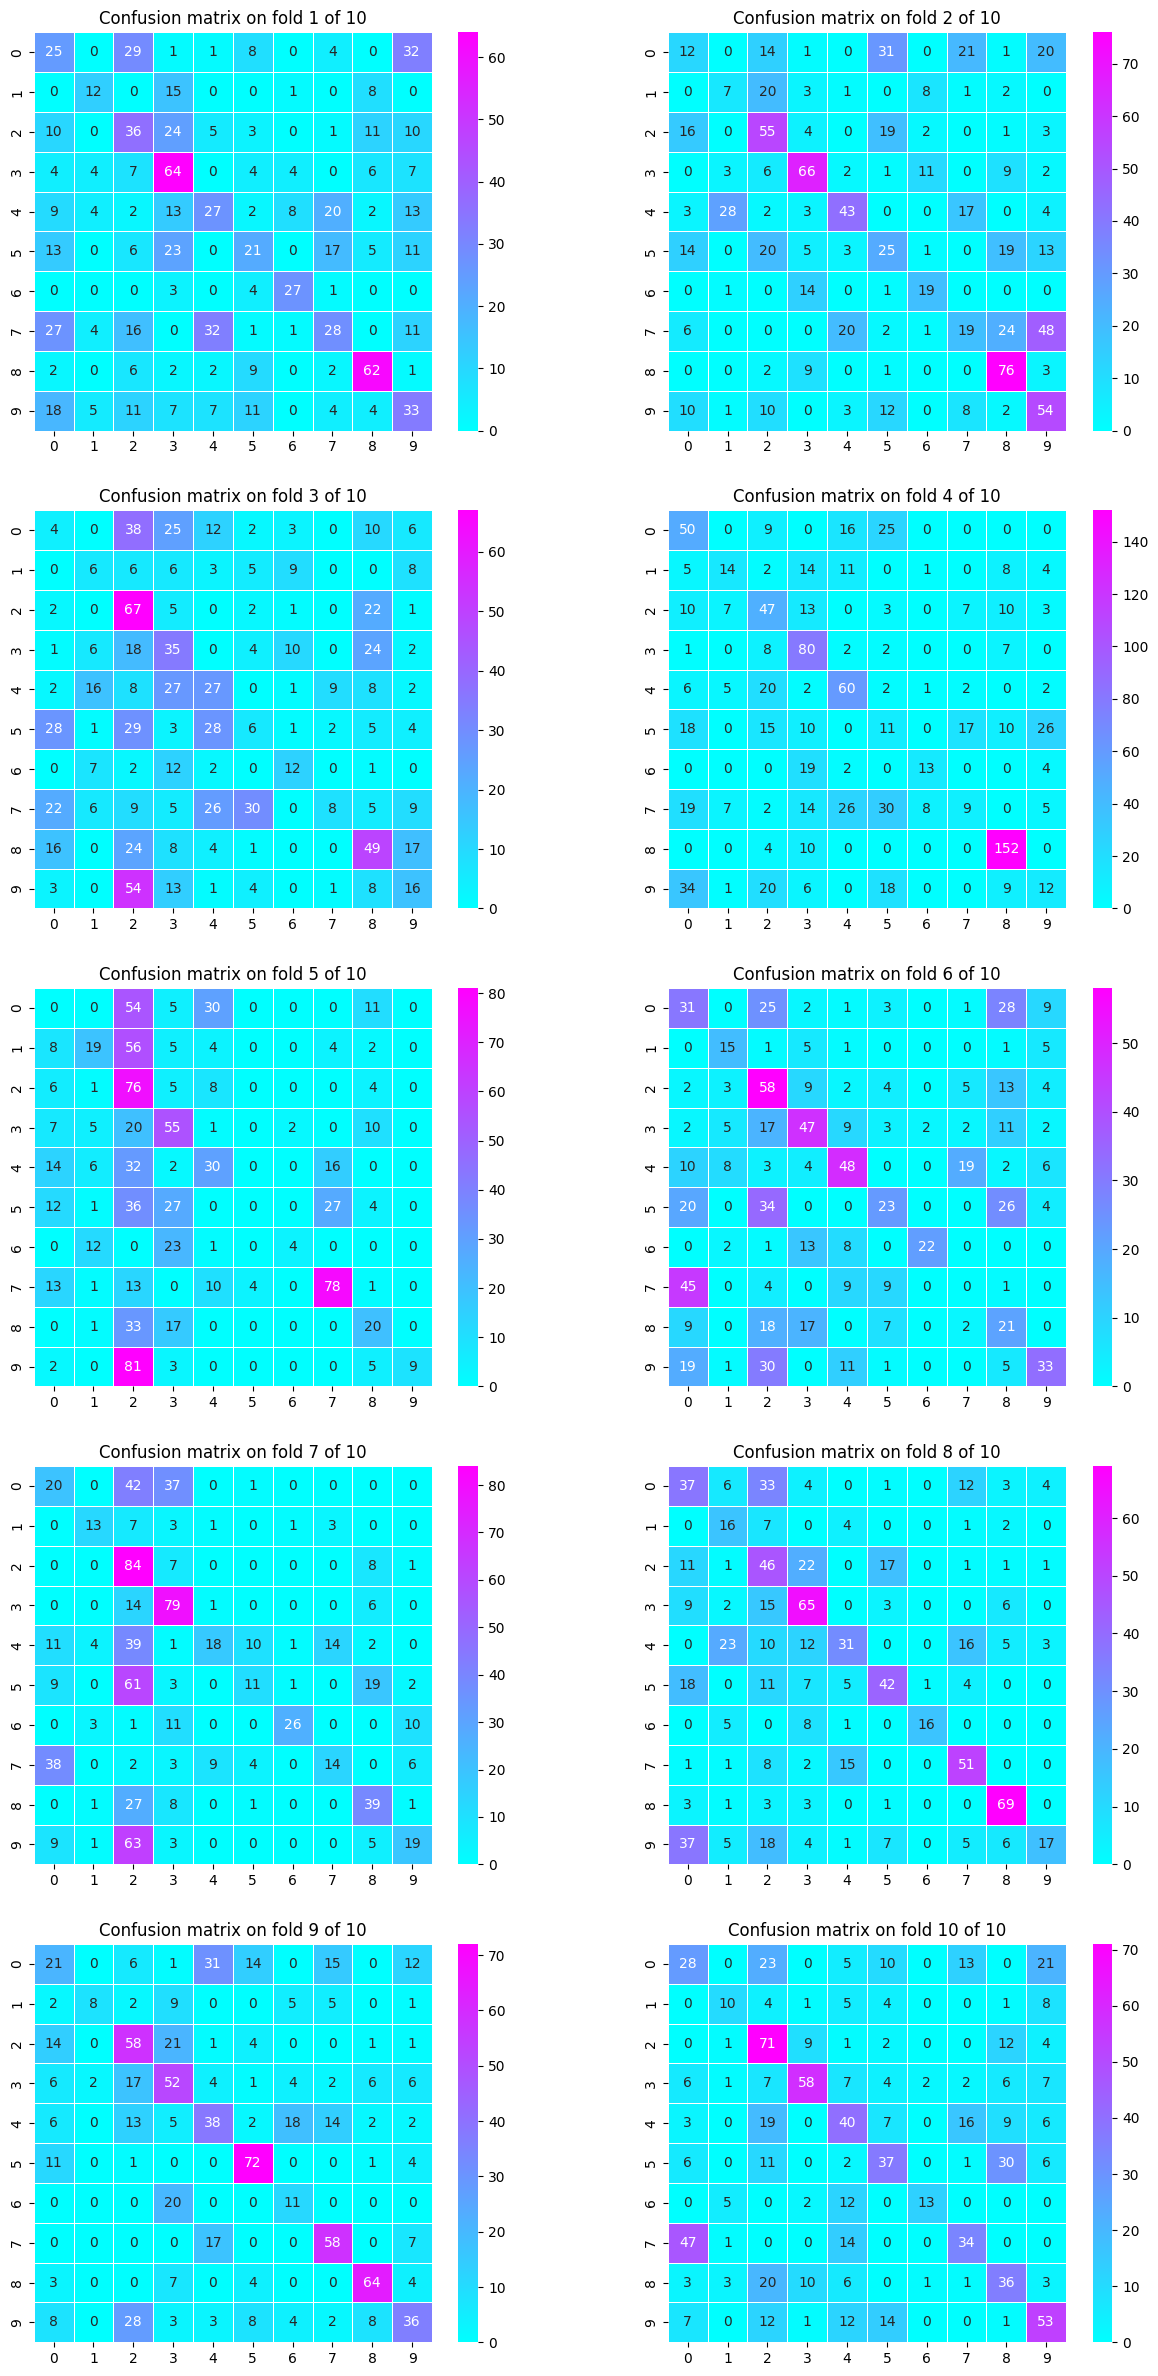

In [26]:
fig, ax =plt.subplots(5, 2, figsize=(15,3*len(fold_metrics)))

for i in range(len(fold_metrics)):
    cm = fold_metrics[i].get('confusion_matrix')
    ax[i//2,i%2].set_title('Confusion matrix on fold '+str(i+1)+' of 10')
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'cool', ax=ax[i//2,i%2])

plt.show()